<a href="https://colab.research.google.com/github/ms03831/nn-HoG-classification-CIFAR10/blob/master/classification_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [2]:
import tensorflow as tf 
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.feature import hog
import cv2
import pandas as pd 
from google.colab.patches import cv2_imshow
from sklearn import svm
import random
from keras import regularizers
from keras.utils.np_utils import to_categorical
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
%matplotlib inline
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


# 1. Loading Dataset:
- ##  About the dataset:
The CIFAR-10 dataset is an image dataset that consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

- ##  preprocessing steps for image data: 
  - resizing 
  - mean-normalisation 
  - capping the RBG values between 0, 1 (0 corresponds to 0 and 1 corresponds to 255)
  - removing noise applying some filter such as guassian blur/smoothing.
  - cropping the image randomly
  - rotating and scaling the image.


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


### Plotting 5 random images

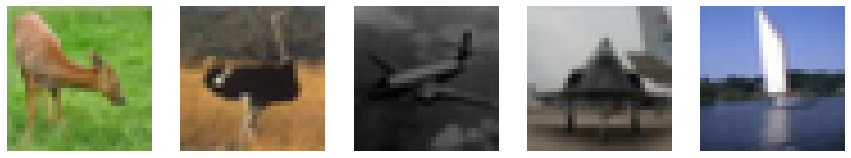

In [0]:
f, ax = plt.subplots(1, 5, figsize=(15, 5))

indexes = random.choices(list(range(0, x_train.shape[0])), k = 5)
for j, i in enumerate(indexes):
  ax[j].imshow(x_train[i])
  ax[j].axis('off')
plt.show()

### Plotting an image from all 10 classes 

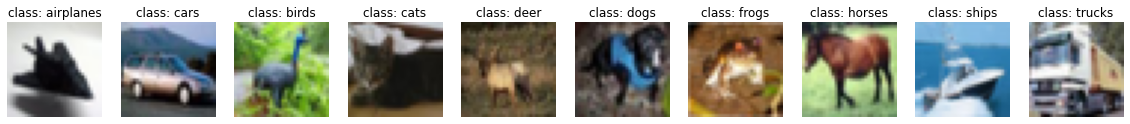

In [0]:
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
f, ax = plt.subplots(1, 10, figsize=(20, 5))
for c in range(10):
    for i, j in zip(x_train, y_train):
        if j == [c]:
            ax[c].imshow(i)
            ax[c].set_title("class: "+(classes[c]))
            ax[c].axis('off')
            break

# 2. Filt
Write a function "filt" whose aim would be to perform the task of filtering. The function should take the
following arguments: input, filter, padding, normalization. The 'input' would be the numpy representation
of an image over which filtering is to be performed - this will either have a single channel or three channels,
'filter' would be a 2D numpy array representing the filter (for example: np.array([[1, 1, 1], [1, 1, 1], [1, 1,
1]]), 'padding' would be a boolean value which would determine as to whether the output image should
have the same size as the input image, and 'normalization' would again be a boolean value which would
determine as to whether the filtering operation needs to be normalized or not. The output of this function
should be the filtered image. Also note that the only external library which can be used in this function is
"numpy"

-----------GAUSSIAN BLUR---------




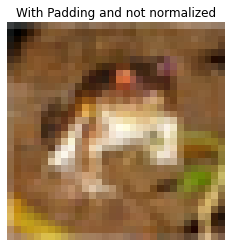

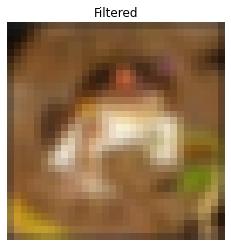

-----------GAUSSIAN BLUR---------




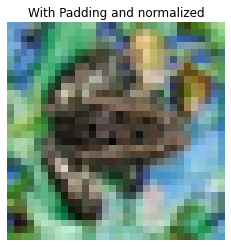

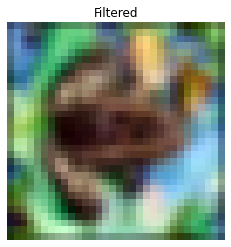

---------GAUSSIAN BLUR------------




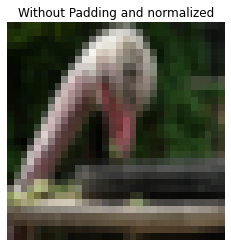

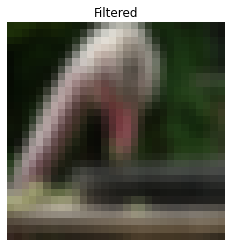

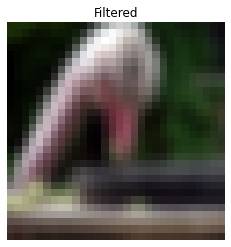

----------GAUSSIAN BLUR-----------




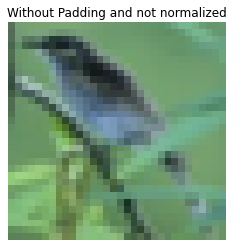

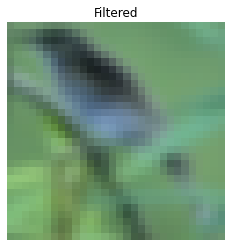

--------EdgeDetection-------




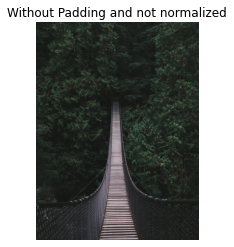

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


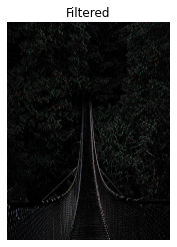

--------EdgeDetection-------




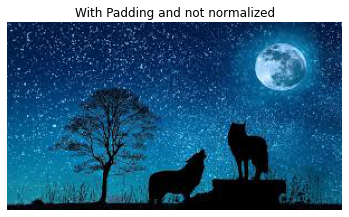

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


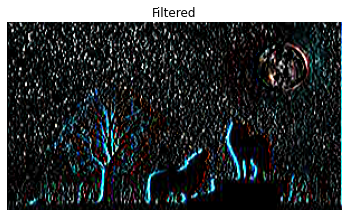

In [10]:
def filt(input, filter, padding, normalization):
    """
    param: input - numpy representation of an input image 
    param: filter - 2D numpy array representing the filter  
    param: padding -  boolean value as to whether the output image should have the same size as the input image
    param: normalization - boolean value as to whether the filtering operation needs to be normalized or not. 
    return: returns the filtered image, as np array
    """
    if len(input.shape) == 2: 
        i_shape = input.shape + (1,)
        input = input.reshape(i_shape)
    assert len(filter.shape) == 2 #filter is 2-d
    n_1, n_2 = filter.shape
    w, h, d = input.shape

    x2 = input
    if padding:
        padding_w = (n_1 - 1)//2
        padding_h = (n_2 - 1)//2
        zero_pad_w = np.zeros((w, padding_w, d))
        input = np.concatenate((zero_pad_w, input, zero_pad_w), axis=1)
        zero_pad_h = np.zeros((padding_h, input.shape[1], d))
        input = np.concatenate((zero_pad_h, input, zero_pad_h), axis=0)
    w, h, d = input.shape
    
    new_shape = (w - n_1 + 1, h - n_2 + 1, d)
    new_image = np.zeros(new_shape)
    

    for i in range(w-n_1+1):
        for j in range(h-n_2+1):
          for k in range(d):
              new_image[i][j][k] = np.sum(input[i:i+n_1, j:j+n_2, k] * filter)
    if new_image.shape[-1] == 1:
        shape = new_image.shape[:2]
        new_image = new_image.reshape(shape)

    if normalization: #normalizes the image to between 0 and 1
        new_image -= np.amin(new_image, axis=(0,1))
        new_image = new_image/np.amax(new_image,axis=(0,1))
     
    plt.imshow(new_image)
    plt.title('Filtered')
    plt.axis('off')
    plt.show()

print('-----------GAUSSIAN BLUR---------\n\n')
img = np.array(x_train[0]).astype(float) / 255.0
plt.imshow(img)
plt.title('With Padding and not normalized')
plt.axis('off')
plt.show()
filter_guass = cv2.getGaussianKernel(3, 0)
filter_guass = np.dot(filter_guass, filter_guass.T)
filt(img, filter_guass, True, False)
print('-----------GAUSSIAN BLUR---------\n\n')
img = np.array(x_train[200]).astype(float) / 255.0
plt.imshow(img)
plt.title('With Padding and normalized')
plt.axis('off')
plt.show()
filter_guass = cv2.getGaussianKernel(3, 0)
filter_guass = np.dot(filter_guass, filter_guass.T)
filt(img, filter_guass, True, True)
print('---------GAUSSIAN BLUR------------\n\n')
img = np.array(x_train[400]).astype(float) / 255.0
plt.imshow(img)
plt.title('Without Padding and normalized')
plt.axis('off')
plt.show()
filter_guass = cv2.getGaussianKernel(3, 0)
filter_guass = np.dot(filter_guass, filter_guass.T)
filt(img, filter_guass, False, False)
filt(img, filter_guass, False, True)
print('----------GAUSSIAN BLUR-----------\n\n')
img = np.array(x_train[800]).astype(float) / 255.0
plt.imshow(img)
plt.title('Without Padding and not normalized')
plt.axis('off')
plt.show()
filter_guass = cv2.getGaussianKernel(3, 0)
filter_guass = np.dot(filter_guass, filter_guass.T)
filt(img, filter_guass, False, False)

custom_image = plt.imread('custom_image.jpeg')
custom_image2 = plt.imread('custom_image2.jpeg')

print('--------EdgeDetection-------\n\n')
filter2 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
img = np.array(custom_image).astype(float) / 255.0
plt.imshow(img)
plt.title('Without Padding and not normalized')
plt.axis('off')
plt.show()
filt(img, filter2, False, False)

print('--------EdgeDetection-------\n\n')
filter2 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
img = np.array(custom_image2).astype(float) / 255.0
plt.imshow(img)
plt.title('With Padding and not normalized')
plt.axis('off')
plt.show()
filt(img, filter2, True, False)

# 3. Classification using HOG
### Extract HOG features from the CIFAR-10 dataset, and train a Linear SVM using those features. You are expected to reach around 45% accuracy on test data using this method. 

### Visualising HOG

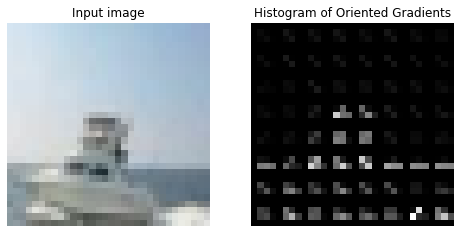

In [0]:
image = x_train[100]

fd, hog_image = hog(image, multichannel=True, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')


ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Helper functions

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def svm_training(xtrain, ytrain):
    """
    param: x_train: numpy array representation of train images
    param: y_train: one-hot encoded labels
    returns: trained SVM classifier
    """
    clf = svm.LinearSVC(C=3, verbose = 1)
    clf.fit(xtrain, ytrain)
    return clf

def hog_features(img):
    fd = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
    return fd

train_features = np.array([hog_features(img) for img in tqdm(x_train)])
test_features = np.array([hog_features(img) for img in tqdm(x_test)])

###Fit and evaluate on Training Data:

In [0]:
y_train = y_train.ravel()
y_test = y_test.ravel() 
clf = svm_training(train_features, y_train)
clf.score(test_features, y_test) 

[LibLinear]

0.5345

###Accuracy on Test Data:

In [0]:
clf.score(train_features, y_train) 

0.55082

### Trying Random Forest:

In [0]:
from sklearn.ensemble import RandomForestClassifier as rf
model = rf()
model.fit(train_features, y_train)
model.score(test_features, y_test) 

0.5237

#4. Neural Networks

## Helpers and data loaders

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.4.0  Device: cuda


In [0]:
#loading data
batch_size = 32

def load_preprocess_data():
    train = datasets.CIFAR10('./data', train=True, download=True, transform = transforms.Compose([
                                            #transforms.RandomCrop(32, padding=2),
                                            #transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    validation = datasets.CIFAR10('./data', train=False, download=True, transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    train_iter = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    validation_iter = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False)
    return train_iter, validation_iter 

train_iter, validation_iter = load_preprocess_data()
train_iter

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#each instance of train_iter contains a pain (i,j) where i is the batch of images, 
#j is the batch of corresponding labels. 

for i, j in train_iter:
  print("X_train batch: {0}\t Y_train batch: {1}".format(np.array(i).shape, np.array(j).shape))
  break

X_train batch: (32, 3, 32, 32)	 Y_train batch: (32,)


In [0]:
def plot_accuracy(train_accuray, validation_accuray):
    plt.plot(train_accuray, label = 'Train')
    plt.plot(validation_accuray, label = 'Validation')
    plt.legend()
    plt.title("Train vs Validation: Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

def plot_loss(train_loss, validation_loss):
    plt.plot(train_loss, label = 'Train')
    plt.plot(validation_loss, label = 'Validation')
    plt.legend()
    plt.title("Train vs Validation: Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

## a. FNN

In [0]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 256)
        self.drop_out1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(256, 128)
        self.drop_out2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)
        self.layers = [self.layer1, self.drop_out1, self.layer2, self.drop_out2, self.layer3, self.out]

    def forward(self, X):
        X = X.view(-1, 32*32*3) #equivalent to reshape.
        for layer in self.layers[:-1]:
            if not isinstance(layer, nn.Dropout):
                X = nn.functional.relu(layer(X))
            else:
                X = layer(X)
        return nn.functional.log_softmax(self.out(X))

model = FNN().to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay = 1e-3)
criterion = nn.CrossEntropyLoss()

print(model)

FNN(
  (layer1): Linear(in_features=3072, out_features=256, bias=True)
  (drop_out1): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (drop_out2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [0]:
def train(epochs, train_loss, validation_loss, train_accuray, validation_accuray):
    # Set model to training mode
    model.train()
    train_los, train_acc = 0, 0
    for epoch in range(1, epochs + 1):
        train_acc = 0
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_iter):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad() 
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_los += loss.data.item()
            pred = output.data.max(1)[1] 
            train_acc += pred.eq(target.data).cpu().sum()

        train_los /= len(train_iter)
        train_loss.append(train_los)
        accuracy = 100. * train_acc.to(torch.float32) / len(train_iter.dataset)
        train_accuray.append(accuracy)
        print("Epoch: {} Training accuracy: {:.0f}% loss: {:.4f}".format(epoch, accuracy, train_los), end = ' ')
        validate(validation_loss, validation_accuray)

def validate(validation_loss, validation_acc):
    model.eval()
    val_loss, val_acc = 0, 0
    for data, target in validation_iter:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        val_acc += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_iter)
    validation_loss.append(val_loss)

    accuracy = 100. * val_acc.to(torch.float32) / len(validation_iter.dataset)
    validation_acc.append(accuracy)
    
    print('Validation loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, val_acc, len(validation_iter.dataset), accuracy))

In [0]:
%%time
train_loss, validation_loss, train_accuray, validation_accuray = [], [], [], []
epochs = 50
train(epochs, train_loss, validation_loss, train_accuray, validation_accuray)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 Training accuracy: 34% loss: 1.8305 Validation loss: 1.6216, accuracy: 4243/10000 (42%)

Epoch: 2 Training accuracy: 43% loss: 1.5902 Validation loss: 1.5264, accuracy: 4611/10000 (46%)

Epoch: 3 Training accuracy: 46% loss: 1.5189 Validation loss: 1.4748, accuracy: 4811/10000 (48%)

Epoch: 4 Training accuracy: 48% loss: 1.4699 Validation loss: 1.4261, accuracy: 4999/10000 (50%)

Epoch: 5 Training accuracy: 49% loss: 1.4357 Validation loss: 1.4100, accuracy: 5032/10000 (50%)

Epoch: 6 Training accuracy: 50% loss: 1.4100 Validation loss: 1.3981, accuracy: 5068/10000 (51%)

Epoch: 7 Training accuracy: 51% loss: 1.3864 Validation loss: 1.3752, accuracy: 5177/10000 (52%)

Epoch: 8 Training accuracy: 52% loss: 1.3663 Validation loss: 1.3581, accuracy: 5287/10000 (53%)

Epoch: 9 Training accuracy: 52% loss: 1.3521 Validation loss: 1.3566, accuracy: 5248/10000 (52%)

Epoch: 10 Training accuracy: 53% loss: 1.3367 Validation loss: 1.3302, accuracy: 5358/10000 (54%)

Epoch: 11 Training 

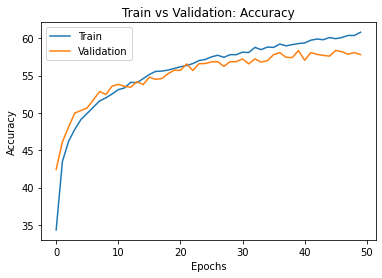

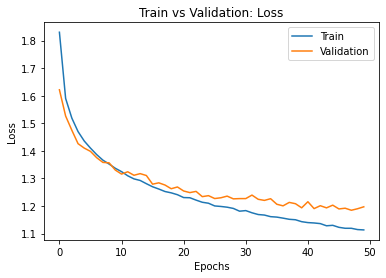

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
plot_accuracy(train_accuray, validation_accuray)
plot_loss(train_loss, validation_loss)
torch.save(model, 'model_58')

In [0]:
model = torch.load('model_58')
model.eval()
val_loss, val_acc = 0, 0
for data, target in validation_iter:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    val_loss += criterion(output, target).data.item()
    pred = output.data.max(1)[1] # get the index of the max log-probability
    val_acc += pred.eq(target.data).cpu().sum()

val_loss /= len(validation_iter)

accuracy = 100. * val_acc.to(torch.float32) / len(validation_iter.dataset)

print('Validation loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, val_acc, len(validation_iter.dataset), accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss: 1.1970, accuracy: 5782/10000 (58%)



## b. CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(0.1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3_drop = nn.Dropout2d(0.1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc1_drop = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2_drop(nn.functional.max_pool2d(self.conv2(x), 2)))
        x = nn.functional.relu(self.conv3_drop(self.conv3(x)))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 256*4*4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc3(self.fc2(self.fc1_drop(x)))
        return nn.functional.log_softmax(x, dim=1)

model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_drop): Dropout2d(p=0.1, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
#loading data
batch_size = 128

def load_preprocess_data():
    train = datasets.CIFAR10('./data', train=True, download=True, transform = transforms.Compose([
                                            transforms.RandomCrop(32, padding=2),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    validation = datasets.CIFAR10('./data', train=False, download=True, transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    train_iter = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    validation_iter = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False)
    return train_iter, validation_iter 

train_iter, validation_iter = load_preprocess_data()
train_iter

Files already downloaded and verified
Files already downloaded and verified


In [0]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

def train(epochs, train_loss, validation_loss, train_accuray, validation_accuray):
    # Set model to training mode
    model.train()
    train_los, train_acc = 0, 0
    for epoch in range(1, epochs + 1):
        train_acc = 0
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_iter):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad() 
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_los += loss.data.item()
            pred = output.data.max(1)[1] 
            train_acc += pred.eq(target.data).cpu().sum()
        scheduler.step()

        train_los /= len(train_iter)
        train_loss.append(train_los)
        accuracy = 100. * train_acc.to(torch.float32) / len(train_iter.dataset)
        train_accuray.append(accuracy)
        print("Epoch: {} Training accuracy: {:.0f}% loss: {:.4f}".format(epoch, accuracy, train_los), end = ' ')
        validate(validation_loss, validation_accuray)

def validate(validation_loss, validation_acc):
    model.eval()
    val_loss, val_acc = 0, 0
    for data, target in validation_iter:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        val_acc += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_iter)
    validation_loss.append(val_loss)

    accuracy = 100. * val_acc.to(torch.float32) / len(validation_iter.dataset)
    validation_acc.append(accuracy)
    
    print('Validation loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, val_acc, len(validation_iter.dataset), accuracy))

In [0]:
%%time
train_loss, validation_loss, train_accuray, validation_accuray = [], [], [], []
epochs = 15
train(epochs, train_loss, validation_loss, train_accuray, validation_accuray)

Epoch: 1 Training accuracy: 39% loss: 1.6392 Validation loss: 1.3269, accuracy: 5156/10000 (52%)

Epoch: 2 Training accuracy: 57% loss: 1.2043 Validation loss: 0.9997, accuracy: 6425/10000 (64%)

Epoch: 3 Training accuracy: 66% loss: 0.9596 Validation loss: 0.8226, accuracy: 7070/10000 (71%)

Epoch: 4 Training accuracy: 71% loss: 0.8319 Validation loss: 0.7672, accuracy: 7340/10000 (73%)

Epoch: 5 Training accuracy: 74% loss: 0.7386 Validation loss: 0.7124, accuracy: 7544/10000 (75%)

Epoch: 6 Training accuracy: 77% loss: 0.6532 Validation loss: 0.6512, accuracy: 7799/10000 (78%)

Epoch: 7 Training accuracy: 79% loss: 0.5962 Validation loss: 0.6352, accuracy: 7817/10000 (78%)

Epoch: 8 Training accuracy: 81% loss: 0.5615 Validation loss: 0.6360, accuracy: 7846/10000 (78%)

Epoch: 9 Training accuracy: 82% loss: 0.5284 Validation loss: 0.5826, accuracy: 8056/10000 (81%)

Epoch: 10 Training accuracy: 83% loss: 0.4897 Validation loss: 0.5673, accuracy: 8132/10000 (81%)

Epoch: 11 Training 

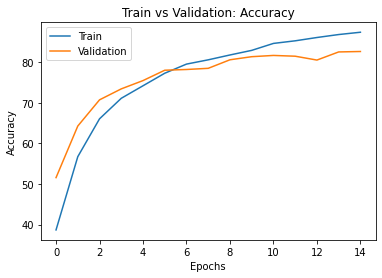

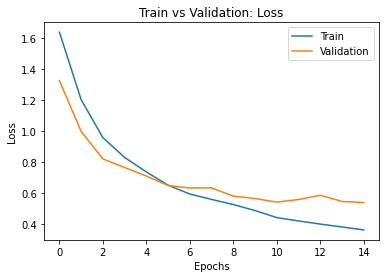

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
plot_accuracy(train_accuray, validation_accuray)
plot_loss(train_loss, validation_loss)
torch.save(model, 'model_80')

## c. Transfer Learning 

In [0]:
def keras_model():
    vgg_model = VGG16(include_top=False,weights='imagenet',input_shape=(64,64,3),classes=10)
    for layer in vgg_model.layers:
        layer.trainable = False
    return tf.keras.Sequential(
            [vgg_model,
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(2048, activation='relu'),
            tf.keras.layers.Dropout(0.2), 
            tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256,  kernel_regularizer=regularizers.l2(0.01), activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128,  kernel_regularizer=regularizers.l2(0.01), activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(10,  kernel_regularizer=regularizers.l2(0.01), activation='softmax')
            ])
    
#learning rate scheduler
def scheduler(epoch, lr): 
    if epoch % 3 == 0 and epoch > 0:
        return lr * 0.5
    return lr


In [0]:
#extra preprocess functions:
def preprocess_imagenet(x_train, x_val):
    x_train = tf.keras.applications.imagenet_utils.preprocess_input(x_train)
    x_val = tf.keras.applications.imagenet_utils.preprocess_input(x_val)
    return x_train, x_val

def zero_center(x_train, x_val):
    mean = x_train.mean(axis=(0, 1, 2))
    std = x_train.std(axis=(0, 1, 2))
    x_train = (x_train - mean) / std
    x_val = (x_val - mean) / std
    return x_train, x_val

def normalize(x_train, x_val):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train/255
    x_val = x_val/255    
    return x_train, x_val


In [0]:
def load_preprocess_TF():
    (x_train,y_train), (x_val,y_val) = cifar10.load_data()
    y_train=to_categorical(y_train)
    y_val=to_categorical(y_val)
    #resize for better performance
    X_train_resized = np.array([cv2.resize(img, (64, 64)) for img in x_train])
    x_val_resized = np.array([cv2.resize(img, (64, 64)) for img in x_val])
    x_train = preprocess_input(X_train_resized)
    x_val = preprocess_input(x_val_resized)
    return (x_train, y_train), (x_val,y_val)

In [11]:
(x_train, y_train), (x_val,y_val) = load_preprocess_TF()
model = keras_model()
adam = tf.keras.optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=x_train, y=y_train, batch_size=128, callbacks=[callback], epochs=10, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/10
391/391 [==============================] - 48s 123ms/step - loss: 18.6126 - accuracy: 0.5518 - val_loss: 14.6915 - val_accuracy: 0.7275 - lr: 2.0000e-04
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 12.1233 - accuracy: 0.6982 - val_loss: 9.5413 - val_accuracy: 0.7587 - lr: 2.0000e-04
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 7.7954 - accuracy: 0.7444 - val_loss: 6.1522 - val_accuracy: 0.7719 - lr: 2.0000e-04
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 5.5280 - accuracy: 0.7713 - val_loss: 4.8961 - val_accuracy: 0.7848 - lr: 1.0000e-04
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 4.3782 - accuracy: 0.7864 - val_loss: 3.8958 - val_accuracy: 0.7906 - lr: 1.0000e-04
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 3.4804 - accuracy: 0.7932 - val_loss: 3.1230 - val_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 7/10
391/391 [=====

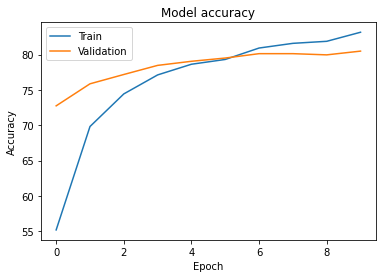

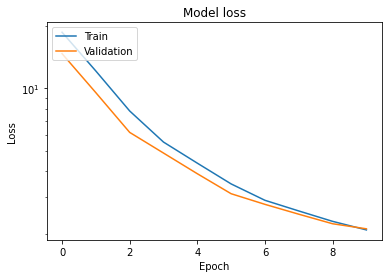

In [12]:
# Plot training & validation accuracy values
acc = [i*100 for i in history.history['accuracy']]
val_acc = [i*100 for i in history.history['val_accuracy']]
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('best_model')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.yscale('log')
plt.show()

## Comments
I tried a bunch of things in this question, from a million architectures to preprocessing techniques to using callbacks. 
- One thing that worked for me in the first part involving feedforward networks was realising that since the dataset is not so huge, I would have to work with a moderately complex network so as to avoid overfitting. First I had as many as 5 layers and 2048 neurons at the start, but that didn't work out so I tried a less complex model, some tweaking with regularisation and normalisation worked wonders. 
- For part b, regularising the network was a challenge, but once that was done I was hitting high 70s easily then I tried some preprocessing techniques, inclduing random flip, random crop and padding, normalising mean and std, and all of them did wonders and I eventually reached 83%. 
- For part c, I tried a bunch of things, nothing seemed to work. Then when discussing with Hiba, we realised that upsampling or resizing the image might do a job. Taking inspiration from that, I tried resizing the image to 64x64, and along with that tried a bunch of other techniques such as image_net preprocessing which didn't work but vgg16 preprocessing worked. Then to further improve on it, I used a learning rate scheduler and that to my expectation worked like wonders and I managed to reach close to 90% validation accuracy. A lower learning rate I realised was also one of the key factors.